In [14]:
%pip install networkx

  Obtaining dependency information for networkx from https://files.pythonhosted.org/packages/b9/54/dd730b32ea14ea797530a4479b2ed46a6fb250f682a9cfb997e968bf0261/networkx-3.4.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ----- ---------------------------------- 0.2/1.7 MB 3.4 MB/s eta 0:00:01
   --------------- ------------------------ 0.7/1.7 MB 6.1 MB/s eta 0:00:01
   ------------------------------- -------- 1.4/1.7 MB 8.7 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 9.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString


In [90]:


# Create synthetic lines for testing
lines = [
    LineString([(0, 0), (5, 5)]),   # Line A
    LineString([(5.2, 5.2), (10, 10)]),  # Line B - near A, same direction
    LineString([(0, 5), (5, 0)]),   # Line C - crosses A, different direction
    LineString([(11, 10), (15, 14)]), # Line D - far, but same angle
    LineString([(6, 7), (6, 11)]),  # Line E - parallel/near B but vertical
    LineString([(5, 7), (5, 11)]),  # Line F - vertical, near A
    LineString([(5, 11.5),(6, 15)]),  # Line G - horizontal, near A
]

gdf = gpd.GeoDataFrame(geometry=lines)


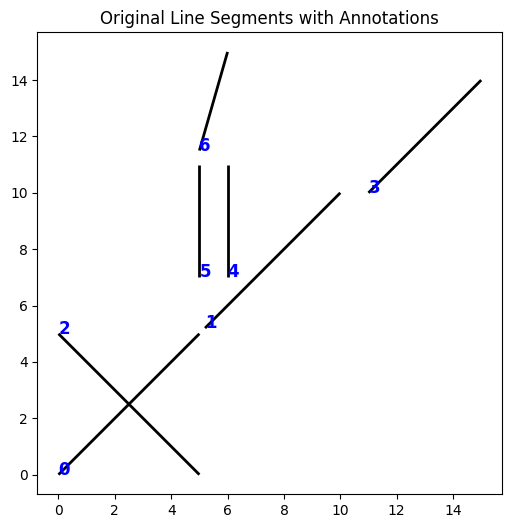

In [91]:
# Plot the lines
fig, ax = plt.subplots(figsize=(6, 6))
gdf.plot(ax=ax, color='black', linewidth=2)

labels = ['0', '1', '2', '3', '4', '5','6']  # Labels for the lines

# Annotate each line with its label
for idx, line in enumerate(gdf.geometry):
    x, y = line.coords[0]  # Get the starting point of the line
    ax.annotate(labels[idx], (x, y), color='blue', fontsize=12, weight='bold')

plt.title("Original Line Segments with Annotations")
plt.axis('equal')
plt.show()


In [56]:
import math

def angle_between_lines(line1, line2):
    def get_angle(line):
        x0, y0 = line.coords[0]
        x1, y1 = line.coords[-1]
        dx = x1 - x0
        dy = y1 - y0
        return math.degrees(math.atan2(dy, dx)) % 180  # modulo 180 to ignore direction

    angle1 = get_angle(line1)
    angle2 = get_angle(line2)
    return abs(angle1 - angle2)




In [57]:
## check angle_between_lines() function
angle_between_lines(lines[0], lines[1])

0.0

In [58]:
## check angle_between_lines() function
angle_between_lines(lines[0], lines[2]) # should be 90 degrees

90.0

In [59]:
## check angle_between_lines() function
angle_between_lines(lines[0], lines[2]) # should be 90 degrees

90.0

In [60]:
## check angle_between_lines() function
angle_between_lines(lines[4], lines[5]) # should be 0 degrees

0.0

In [ ]:
## check angle_between_lines() function
angle_between_lines(lines[5], lines[6]) # should be 15.9 degrees

15.945395900922847

In [93]:
## check angle_between_lines() function
angle_between_lines(lines[4], lines[6]) # should be 15.9 degrees

15.945395900922847

In [61]:
## check angle_between_lines() function
angle_between_lines(lines[1], lines[3]) # should be 0 degrees

0.0

In [ ]:
## check angle_between_lines() function
angle_between_lines(lines[1], lines[3]) # should be 0 degrees

0.0

In [62]:
from shapely.geometry import Point

def endpoints_close(line1, line2, dist_thresh=1.0):
    ends1 = [Point(c) for c in [line1.coords[0], line1.coords[-1]]]
    ends2 = [Point(c) for c in [line2.coords[0], line2.coords[-1]]]
    return any(p1.distance(p2) < dist_thresh for p1 in ends1 for p2 in ends2)


In [63]:
## Check endpoints_close() function
endpoints_close(lines[0],lines[1], 2.0) # should be true


True

In [64]:
## Check endpoints_close() function
endpoints_close(lines[4],lines[5],2.0) # should be true 


True

In [65]:
## Check endpoints_close() function
endpoints_close(lines[0],lines[5],2.0) # should be false 


False

In [66]:
## Check endpoints_close() function
endpoints_close(lines[1],lines[3],2.0) # should be true 


True

In [84]:
## Check endpoints_close() function
endpoints_close(lines[4],lines[5],1.0) # should be False notice distance threshold is 1.0


False

In [96]:
endpoints_close(lines[5],lines[6],0.6) # should be True 

True

In [119]:
def directional_collinearity_score(line1, line2):
    """
    Computes a 'collinearity score' based on how well line2 continues from line1.
    Lower scores mean better directional collinearity.
    """
    from shapely.geometry import Point
    from shapely.ops import nearest_points

    # Get end of line1
    end1 = Point(line1.coords[-1])
    
    # Direction vector of line1
    dx = line1.coords[-1][0] - line1.coords[0][0]
    dy = line1.coords[-1][1] - line1.coords[0][1]
    length1 = math.hypot(dx, dy)
    if length1 == 0:
        return float('inf')  # degenerate line
    
    ux, uy = dx / length1, dy / length1

    # Find closest point on line2 to end of line1
    nearest_on_line2 = nearest_points(end1, line2)[1]
    d = end1.distance(nearest_on_line2)

    # Project line1 forward by d
    projected = Point(end1.x + ux * d, end1.y + uy * d)

    # Measure how close this projected point is to the *start* of line2
    start2 = Point(line2.coords[0])
    return projected.distance(start2)

In [ ]:
directional_collinearity_score(lines[0], lines[1]) # should be 0


0.0

In [121]:
directional_collinearity_score(lines[1], lines[3]) # should be 0


0.7653668647301798

In [122]:
directional_collinearity_score(lines[5], lines[4]) # should be 0


5.0990195135927845

In [123]:
directional_collinearity_score(lines[4], lines[6]) # should be 0


1.1755705045849463

In [125]:
directional_collinearity_score(lines[5], lines[6]) # should be 0


0.0

In [127]:
def is_merge_candidate(line1, line2, angle_thresh=10, dist_thresh=2.0, collinearity_thresh=1.0):
    """
    Uses angle, endpoint proximity, and directional collinearity score.
    """
    if angle_between_lines(line1, line2) > angle_thresh:
        return False
    if not endpoints_close(line1, line2, dist_thresh):
        return False
    score = directional_collinearity_score(line1, line2)
    return score < collinearity_thresh

In [133]:
is_merge_candidate(lines[0], lines[1],angle_thresh=0.5, dist_thresh=0.3, collinearity_thresh=0.1) # should be true even at very low values

True

In [ ]:
is_merge_candidate(lines[1], lines[3],angle_thresh=10, dist_thresh=2.0, collinearity_thresh=1.0)  # should be true

True

In [ ]:
is_merge_candidate(lines[1], lines[3],angle_thresh=0, dist_thresh=2.0, collinearity_thresh=0.5) # should be false as we decrease colinearity threshold

False

In [ ]:
is_merge_candidate(lines[1], lines[3],angle_thresh=0, dist_thresh=1.0, collinearity_thresh=1) # should be false as we decrease distance threshold

False

## STOPED HERE, NEED TO FINISH

In [23]:
def extend_line(line, distance=2.0):
    from shapely.geometry import LineString
    x0, y0 = line.coords[0]
    x1, y1 = line.coords[-1]

    dx = x1 - x0
    dy = y1 - y0
    length = math.hypot(dx, dy)
    ux = dx / length
    uy = dy / length

    new_start = (x0 - ux * distance, y0 - uy * distance)
    new_end = (x1 + ux * distance, y1 + uy * distance)
    return LineString([new_start, new_end])

In [70]:
# Extend lines for snapping checks only
extension_dist = 2.0  # You can tweak this!
extended_lines = [extend_line(line, distance=extension_dist) for line in gdf.geometry]

merge_pairs = []

for i, line1 in enumerate(extended_lines):
    for j, line2 in enumerate(extended_lines):
        if i >= j:
            continue
        if is_merge_candidate(line1, line2, angle_thresh=10, dist_thresh=2.0):
            merge_pairs.append((i, j))

print("Merge Candidates (by index):", merge_pairs)


Merge Candidates (by index): [(4, 5)]


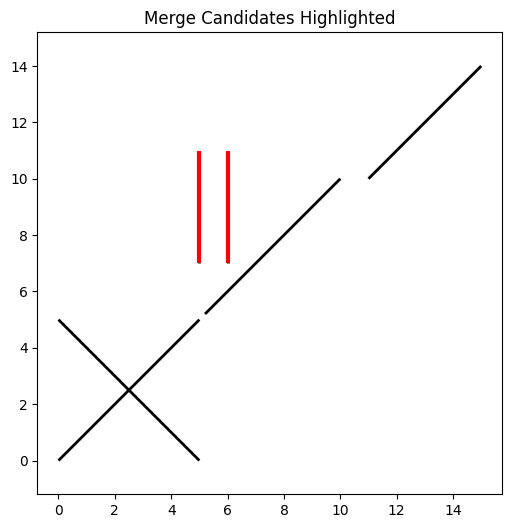

In [71]:
import matplotlib.pyplot as plt

# Base plot: all lines in black
fig, ax = plt.subplots(figsize=(6, 6))
gdf.plot(ax=ax, color='black', linewidth=2)

# Highlight merge candidate pairs in red
for i, j in merge_pairs:
    gdf.iloc[[i, j]].plot(ax=ax, color='red', linewidth=3)

plt.title("Merge Candidates Highlighted")
plt.axis('equal')
plt.show()

In [72]:
import networkx as nx

# Build graph from merge pairs
G = nx.Graph()
G.add_edges_from(merge_pairs)

# Each connected component is a group of indices to merge
groups = list(nx.connected_components(G))
print("Line groups to merge:", groups)

Line groups to merge: [{4, 5}]


In [73]:
from shapely.ops import linemerge, unary_union

merged_lines = []
merged_indices = set()

for group in nx.connected_components(nx.Graph(merge_pairs)):
    group = list(group)
    lines_to_merge = [gdf.geometry[i] for i in group]  # original lines
    merged = linemerge(unary_union(lines_to_merge))
    merged_lines.append(merged)
    merged_indices.update(group)

# Add unmerged lines
unmerged_lines = [gdf.geometry[i] for i in range(len(gdf)) if i not in merged_indices]
final_lines = merged_lines + unmerged_lines

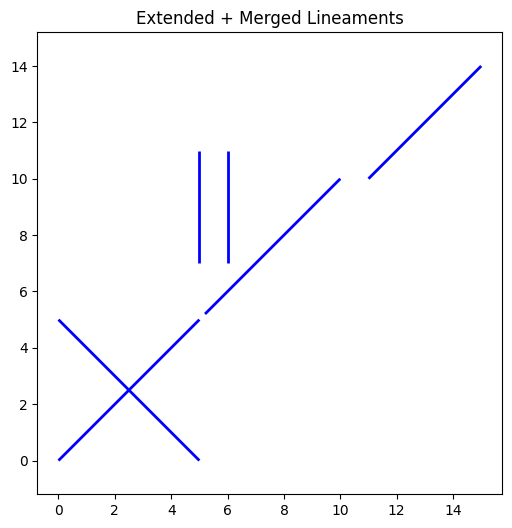

In [74]:
merged_gdf = gpd.GeoDataFrame(geometry=final_lines)

fig, ax = plt.subplots(figsize=(6, 6))
merged_gdf.plot(ax=ax, color='blue', linewidth=2)
plt.title("Extended + Merged Lineaments")
plt.axis('equal')
plt.show()